In [178]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from scipy import stats



In [179]:
# Đọc dữ liệu
df = pd.read_csv("D:/TImeserri/Gia SMP va SMPcap 2021(Giá thị trường SMP).csv", encoding="latin-1", sep=';', index_col=0)
feats = ['4']
df = df[feats]

# Chuyển đổi index sang dạng datetime
df.index = pd.to_datetime(df.index, dayfirst=True)

# Sắp xếp dữ liệu theo ngày
df = df.sort_index()
df

,4
Date,
2021-01-01,964.4
2021-01-02,964.4
2021-01-03,988.3
2021-01-04,988.4
2021-01-05,930.6
...,...
2021-12-27,1002.0
2021-12-28,1002.0
2021-12-29,1061.5


In [180]:
# Chia dữ liệu thành train và test theo tỉ lệ 8:2
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Chuẩn bị dữ liệu cho mô hình HMM
X_train = np.array(train).reshape(-1, 1)
X_test = np.array(test).reshape(-1, 1)

In [181]:
# Xây dựng và huấn luyện mô hình GaussianHMM
model = GaussianHMM(n_components=4, n_iter=1000, random_state=42)
model.fit(X_train)

GaussianHMM(n_components=4, n_iter=1000, random_state=42)

In [182]:
# Dự đoán giá trị trên tập test
logprob, predicted_states = model.decode(X_test, algorithm="viterbi")

# Tạo DataFrame cho dự đoán
predicted_values = model.means_[predicted_states]
pred_df = pd.DataFrame(predicted_values, index=test.index, columns=['Predicted'])

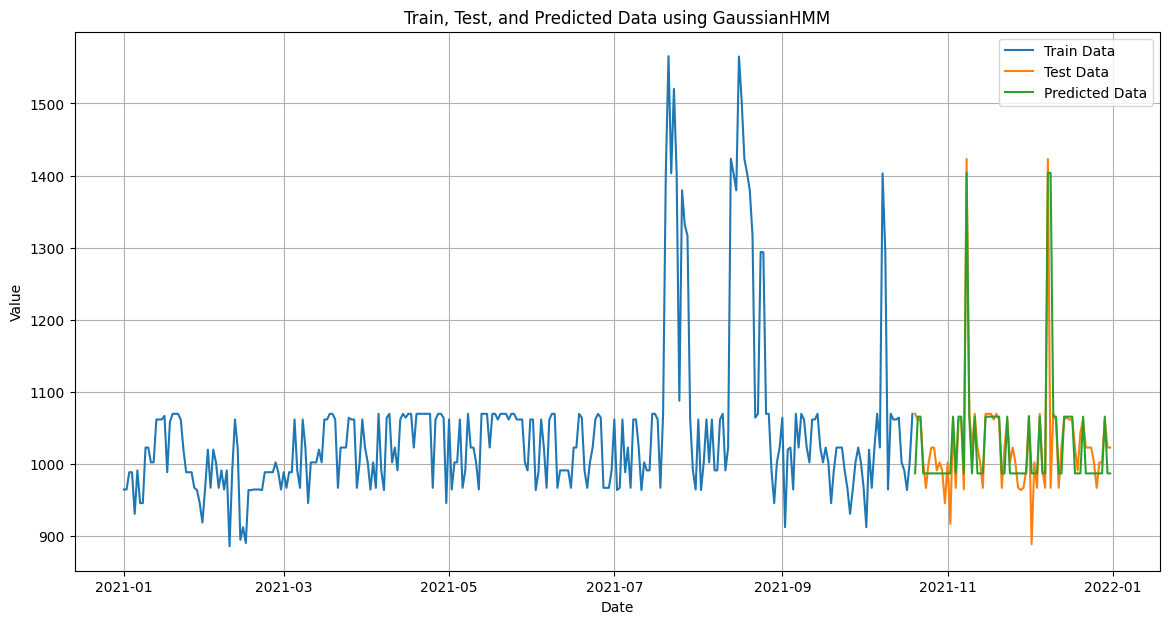

In [183]:
# Vẽ biểu đồ đường cho dữ liệu train, test và dự đoán
plt.figure(figsize=(14, 7))
plt.plot(train.index, train.values, label='Train Data')
plt.plot(test.index, test.values, label='Test Data')
plt.plot(pred_df.index, pred_df.values, label='Predicted Data')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Train, Test, and Predicted Data using GaussianHMM')
plt.legend()
plt.grid(True)
plt.show()


# HMM kết hợp KALMAN

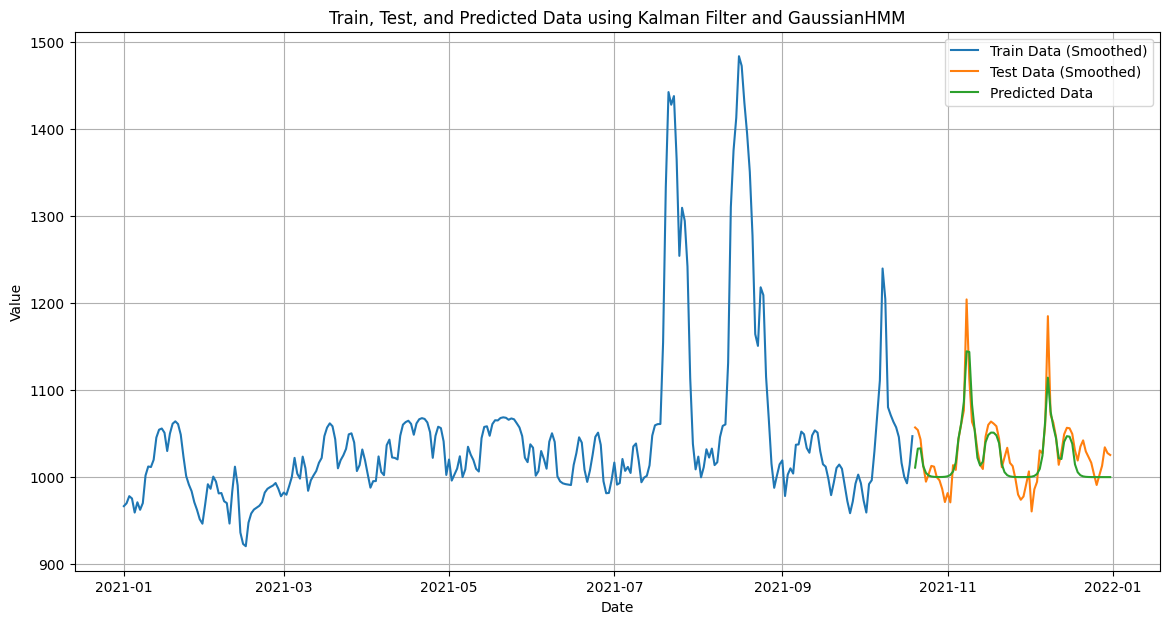

In [184]:
# Áp dụng bộ lọc Kalman cho tập dữ liệu ban đầu
kf = KalmanFilter(initial_state_mean=df.values[0], n_dim_obs=1)
state_means, _ = kf.smooth(df.values)

# Tạo DataFrame cho dữ liệu đã được làm mượt
smoothed_df = pd.DataFrame(state_means, index=df.index, columns=['Smoothed'])

# Chia dữ liệu đã được làm mượt thành train và test theo tỉ lệ 8:2
train_size = int(len(smoothed_df) * 0.8)
train, test = smoothed_df[:train_size], smoothed_df[train_size:]

# Chuẩn bị dữ liệu cho mô hình HMM
X_train = np.array(train).reshape(-1, 1)
X_test = np.array(test).reshape(-1, 1)

# Xây dựng và huấn luyện mô hình GaussianHMM
model = GaussianHMM(n_components=4, n_iter=1000, random_state=42)
model.fit(X_train)

# Dự đoán giá trị trên tập test
logprob, predicted_states = model.decode(X_test, algorithm="viterbi")

# Lấy giá trị trung bình của các trạng thái dự đoán
predicted_values = model.means_[predicted_states]

# Áp dụng bộ lọc Kalman để làm mượt các dự đoán
kf = KalmanFilter(initial_state_mean=predicted_values[0], n_dim_obs=1)
state_means, _ = kf.smooth(predicted_values)

# Tạo DataFrame cho dự đoán
pred_df = pd.DataFrame(state_means, index=test.index, columns=['Predicted'])

# Vẽ biểu đồ đường cho dữ liệu train, test và dự đoán
plt.figure(figsize=(14, 7))
plt.plot(train.index, train.values, label='Train Data (Smoothed)')
plt.plot(test.index, test.values, label='Test Data (Smoothed)')
plt.plot(pred_df.index, pred_df.values, label='Predicted Data')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Train, Test, and Predicted Data using Kalman Filter and GaussianHMM')
plt.legend()
plt.grid(True)
plt.show()


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
         1   -1867.75729090             +nan
         2   -1644.64964373    +223.10764717
         3   -1540.67215878    +103.97748495
         4   -1513.67944063     +26.99271815
         5   -1508.27498686      +5.40445378
         6   -1506.41977202      +1.85521484
         7   -1505.46174120      +0.95803082
         8   -1504.88391687      +0.57782433
         9   -1

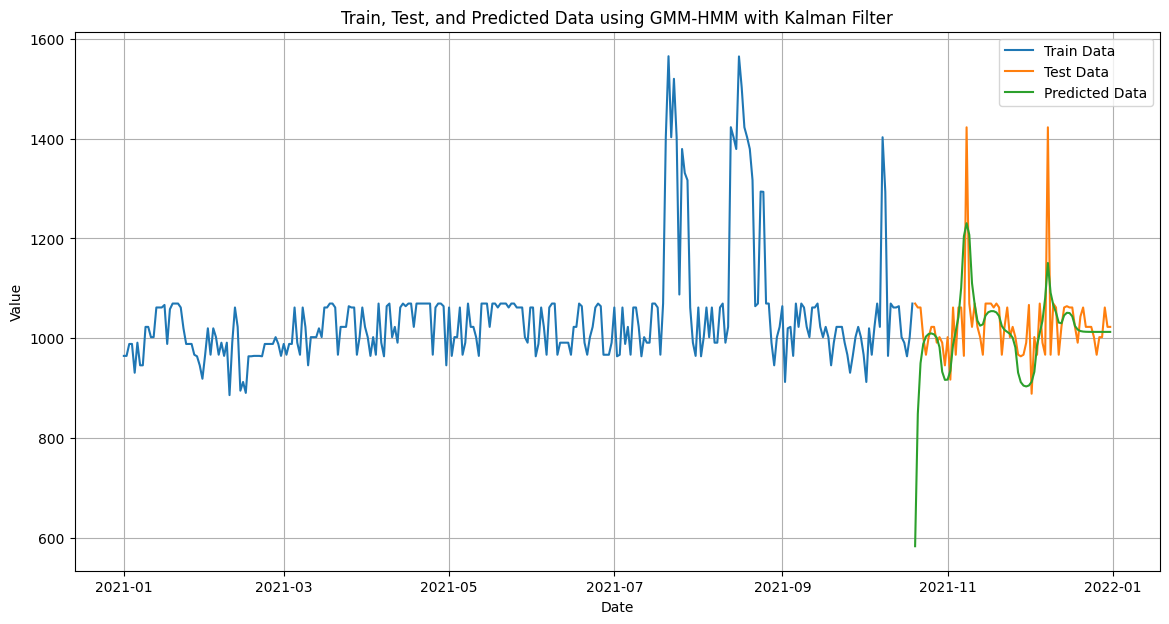

In [186]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GMMHMM
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Đọc dữ liệu
df = pd.read_csv("D:/TImeserri/Gia SMP va SMPcap 2021(Giá thị trường SMP).csv", encoding="latin-1", sep=';', index_col=0)
feats = ['4']
df = df[feats]

# Chuyển đổi index sang dạng datetime
df.index = pd.to_datetime(df.index, dayfirst=True)

# Sắp xếp dữ liệu theo ngày
df = df.sort_index()

# Chuyển đổi dữ liệu thành mảng 2D cho bộ lọc Kalman
observations = df.values.reshape(-1, 1)

# Áp dụng bộ lọc Kalman lên dữ liệu ban đầu
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
state_means, _ = kf.smooth(observations)
df['Kalman'] = state_means

# Chia dữ liệu thành train và test theo tỉ lệ 8:2
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Chuẩn bị dữ liệu cho mô hình HMM
X_train = np.array(train['Kalman']).reshape(-1, 1)
X_test = np.array(test['Kalman']).reshape(-1, 1)

# Khởi tạo mô hình GMM-HMM với các tham số xác suất khởi tạo và xác suất chuyển tiếp
model = GMMHMM(n_components=4, n_mix=3, n_iter=1000, random_state=42, verbose=True)
model.startprob_ = np.full(model.n_components, 1 / model.n_components)
model.transmat_ = np.full((model.n_components, model.n_components), 1 / model.n_components)

# Khởi tạo các tham số của mô hình để tránh lỗi ValueError
model.means_ = np.random.rand(model.n_components, model.n_mix, 1)
model.covars_ = np.tile(np.identity(1), (model.n_components, model.n_mix, 1, 1))
model.weights_ = np.full((model.n_components, model.n_mix), 1 / model.n_mix)

# Huấn luyện mô hình GMM-HMM
model.fit(X_train)

# Dự đoán giá trị trên tập test
logprob, predicted_states = model.decode(X_test, algorithm="viterbi")

# Lấy giá trị trung bình của các trạng thái dự đoán
predicted_means = np.array([model.means_[state].mean() for state in predicted_states]).reshape(-1, 1)

# Áp dụng bộ lọc Kalman lên các giá trị dự đoán
predicted_values_kalman, _ = kf.smooth(predicted_means)

# Tạo DataFrame cho dự đoán
pred_df = pd.DataFrame(predicted_values_kalman, index=test.index, columns=['Predicted'])

# Vẽ biểu đồ đường cho dữ liệu train, test và dự đoán
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['4'], label='Train Data')
plt.plot(test.index, test['4'], label='Test Data')
plt.plot(pred_df.index, pred_df.values, label='Predicted Data')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Train, Test, and Predicted Data using GMM-HMM with Kalman Filter')
plt.legend()
plt.grid(True)
plt.show()
